### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

Описание данных:
Набор данных семян пшеницы включает в себя прогнозирование видов с учетом измерений семян из разных сортов пшеницы.

Это бинарная (2-классная) задача классификации. Количество наблюдений для каждого класса сбалансировано. Есть 210 наблюдений с 7 входными переменными и 1 выходной переменной. Имена переменных следующие:

Площадь.
Периметр.
Компактность
Длина ядра.
Ширина ядра.
Коэффициент асимметрии.
Длина желобка ядра.
Класс (1, 2, 3).

In [421]:
import pandas as pd
import numpy as np
data = pd.read_csv("seeds_dataset.csv",sep=';')
data.head(3)

,Площадь,Периметр,Компакность,Длина ядра,Ширина ядра,Коэффициент ассиметрии,Длина желобка ядра,Класс
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1


У нас есть 7 признаков и 1 целевая переменная (бинарная) - нужно определить сорт пшеницы.

In [422]:
print(data.shape)

(210, 8)


Посмотрим на соотношение классов

In [423]:
data.iloc[:, -1].value_counts()

1    70
2    70
3    70
Name: Класс, dtype: int64

In [424]:
import matplotlib.pylab as plt

Визуализируем данные от 2-х в зависимости от 2-х признаков 1-го и последнеднего.

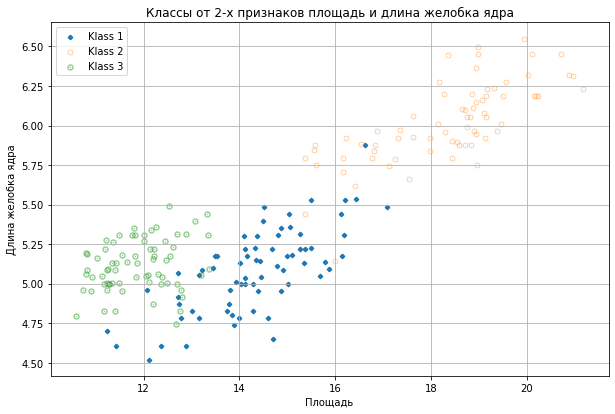

In [425]:
plt.figure(figsize=(10, 6.5))
plt.scatter(data.iloc[:, 0].where(data.iloc[:, 7]==1), data.iloc[:, 6].where(data.iloc[:, 7]==1), marker="x", linewidth=4, s=8, alpha=1, label='Klass 1');
plt.scatter(data.iloc[:, 0].where(data.iloc[:, 7]==2), data.iloc[:, 6].where(data.iloc[:, 7]==2),marker='.', linewidth=5, s=2, alpha=0.5, label='Klass 2');
plt.scatter(data.iloc[:, 0].where(data.iloc[:, 7]==3), data.iloc[:, 6].where(data.iloc[:, 7]==3),marker='o', linewidth=5, s=2, alpha=0.5, label='Klass 3');
plt.title('Классы от 2-х признаков площадь и длина желобка ядра')
plt.xlabel("Площадь")
plt.ylabel("Длина желобка ядра")
plt.grid()
plt.legend()

Так как нужны данные для бинарной классификации, удалим из датасета данные третьего класса. И заменим 1 и 2 на 0 и 1.

In [426]:
data = data[data['Класс'] !=3]
data.head()

,Площадь,Периметр,Компакность,Длина ядра,Ширина ядра,Коэффициент ассиметрии,Длина желобка ядра,Класс
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [427]:
data['Класс'] = data['Класс'].replace([1, 2], [0, 1])
data.head()

,Площадь,Периметр,Компакность,Длина ядра,Ширина ядра,Коэффициент ассиметрии,Длина желобка ядра,Класс
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [428]:
data.iloc[:, -1].value_counts()

0    70
1    70
Name: Класс, dtype: int64

Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [429]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [430]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

Проверяем качество

In [431]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return [f1,roc,rec,prc]
    
res1 = evaluate_results(y_test, y_predict)

Classification results:
f1: 100.00%
roc: 100.00%
recall: 100.00%
precision: 100.00%


### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [519]:
mod_data = data.copy()
#получим индексы положительных выборок
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#перемешаем их
np.random.shuffle(pos_ind)
# оставим отмеченными только 25% положительных результатов
#pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
#pos_sample_len = int(np.ceil(0.2 * len(pos_ind)))
pos_sample_len = int(np.ceil(0.5 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные и снимаем метку с остальных')
pos_sample = pos_ind[:pos_sample_len]

Используем 35/70 как позитивные и снимаем метку с остальных


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [520]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    105
 1     35
Name: class_test, dtype: int64


Теперь у нас есть только 18 положительных образца, помеченных как 1 в таблице 'class_test', в то время как остальные не помечены как -1.

In [521]:
mod_data.where(mod_data['class_test']==1).tail(70)

,Площадь,Периметр,Компакность,Длина ядра,Ширина ядра,Коэффициент ассиметрии,Длина желобка ядра,Класс,class_test
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,17.26,15.73,0.8763,5.978,3.594,4.539,5.791,1.0,1.0
73,19.11,16.26,0.9081,6.154,3.930,2.936,6.079,1.0,1.0
74,16.82,15.51,0.8786,6.017,3.486,4.004,5.841,1.0,1.0
...,...,...,...,...,...,...,...,...,...
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,17.36,15.76,0.8785,6.145,3.574,3.526,5.971,1.0,1.0
137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,15.60,15.11,0.8580,5.832,3.286,2.725,5.752,1.0,1.0


Помните, что этот фрейм данных (x_data) включает в себя прежнюю целевую переменную, которую мы сохраняем здесь только для сравнения результатов

[:-2] - это исходная метка класса для положительных и отрицательных данных [:-1] - это новый класс для положительных и немаркированных данных

In [522]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [523]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(35, 9) (35, 9)


In [524]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
#res2 = evaluate_results(sample_test.iloc[:,-2].values, y_predict) #для доли Р = 25%
#res3 = evaluate_results(sample_test.iloc[:,-2].values, y_predict) #для доли Р = 20%
res4 = evaluate_results(sample_test.iloc[:,-2].values, y_predict) #для доли Р = 50%

Classification results:
f1: 95.83%
roc: 96.83%
recall: 95.83%
precision: 95.83%


In [525]:
tabledata = [["решение_1",res1[0],res1[1],res1[2],res1[3]],
            ["доля 25%",res2[0],res2[1],res2[2],res2[3]],
            ["доля 20%",res3[0],res3[1],res3[2],res3[3]],
            ["доля 50%",res4[0],res4[1],res4[2],res4[3]]]

In [526]:
pd.DataFrame(tabledata, columns=["решение","f1","roc", "recall","precision"])

,решение,f1,roc,recall,precision
0,решение_1,1.000000,1.000000,1.000000,1.000000
1,доля 25%,0.956522,0.961019,0.956522,0.956522
2,доля 20%,0.947368,0.955646,0.957447,0.937500
3,доля 50%,0.958333,0.968297,0.958333,0.958333


При увеличении доли Р качество модели растет.

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

На практике более предподчтительным является random negative sampling, так как RNS одностадийный и простой,но плохо работает если смещено распределение генеральной совокупности, поэтому данных должно быть много, если данных мало не сработает. В 2-step approach придумываются негативные данные и нельзя проконтролировать насколько хорошо они построены.